# Reinforcement Learning
### Constant-alpha Greedy-in-the-Limit-with-Infinite-Exploration Monte Carlo Control Prediction

..or just <b>Constant-$\alpha$ GLIE MC Control</b> :)

This notebook is mostly  borrowed / created / compressed from udacitys <b>Machine Learning Negineer Nanodegree</b> course, mixed with my own code/words and text from wiki.<br>

Reinforcement learning involves an agent, a set of states $\displaystyle S$, and a set $\displaystyle A$ of actions per state. By performing an action $\displaystyle a\in A$, the agent transitions from state to state. Executing an action in a specific state provides the agent with a reward (a numerical score).

In [1]:
# some base imports
import gym
import numpy as np
from collections import defaultdict
import sys
from IPython.display import clear_output
%matplotlib inline


In [2]:
# Let's load the blackjack gym!
env = gym.make('Blackjack-v0')

Lets check out the observation space..

In [3]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

In [4]:
# Theoretical number of possible states..
32*11*2

704

..and the action space ..

In [5]:
env.action_space

Discrete(2)

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

Lets just try it out..

In [6]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
        else:
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
        break

(12, 3, False)
End game! Reward:  1.0
(15, 10, True)
You lost :(

(13, 2, True)
You lost :(



Lets borrow some nice plotting routines ...

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

And to the core stuff..

<img width=500 src="https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dfe21e_mc-control-constant-a/mc-control-constant-a.png">

In [9]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q_alpha(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [10]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            policy = dict((k,np.argmax(v)) for k, v in Q.items())
            clear_output(wait=True)
            plot_policy(policy)
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

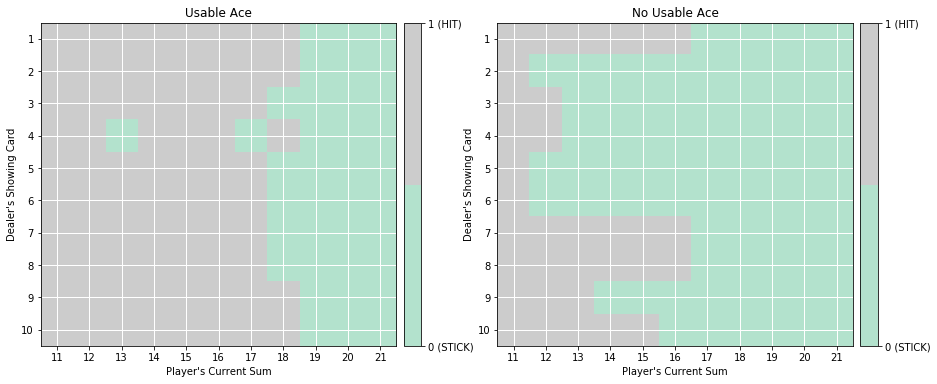

Episode 250000/250000.

In [11]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 250000, 0.02)

In [12]:
len(policy_alpha)

280

policy_alpha ( best estimated policy ) = 
```python
{(6, 10, False): 1,
 (13, 10, False): 1,
 (18, 10, False): 0,
 (20, 10, False): 0,
 (11, 10, False): 1,
...
```

Q_alpha ( action-values ) = 
```python
    {(6, 10, False): array([-0.60535963, -0.31988675]),
     (13, 10, False): array([-0.6668346 , -0.29077042]),
     (18, 10, False): array([-0.22648765, -0.63908157]),
     (20, 10, False): array([ 0.51388405, -0.82778103]),
...
```

<b>Q</b> is the state value or next action for a given state and action.

<b>policy</b> $\pi$ in this case is equal to $\epsilon$-greedy(<b>Q</b>).<br>
The policy just states what action to take depending on what we have encountered and what reward we got in the past.

<b>alpha</b> is the forgetting mean factor (<b>Explore vs Exploit</b>).<br>
1 means only look at the last value and 0 will never remember anything.<br>
small values close to zero enlongates the range compared to close to one.

<b>epsilon</b> $\epsilon$ - You can think of the agent who follows an $\epsilon$-greedy policy as always having a (potentially unfair) coin at its disposal, with probability $\epsilon$ of landing heads. After observing a state, the agent flips the coin.

<b>gamma</b> - The discount factor $\displaystyle \gamma$ determines the importance of future rewards. A factor of 0 will make the agent "myopic" (or short-sighted) by only considering current rewards, while a factor approaching 1 will make it strive for a long-term high reward.<br>
$\gamma$  (the discount factor) is a number between 0 and 1 ( $\displaystyle 0\leq \gamma \leq 1$ ) and has the effect of valuing rewards received earlier higher than those received later (reflecting the value of a "good start"). $\displaystyle \gamma $ may also be interpreted as the probability to succeed (or survive) at every step $\displaystyle \Delta t$.

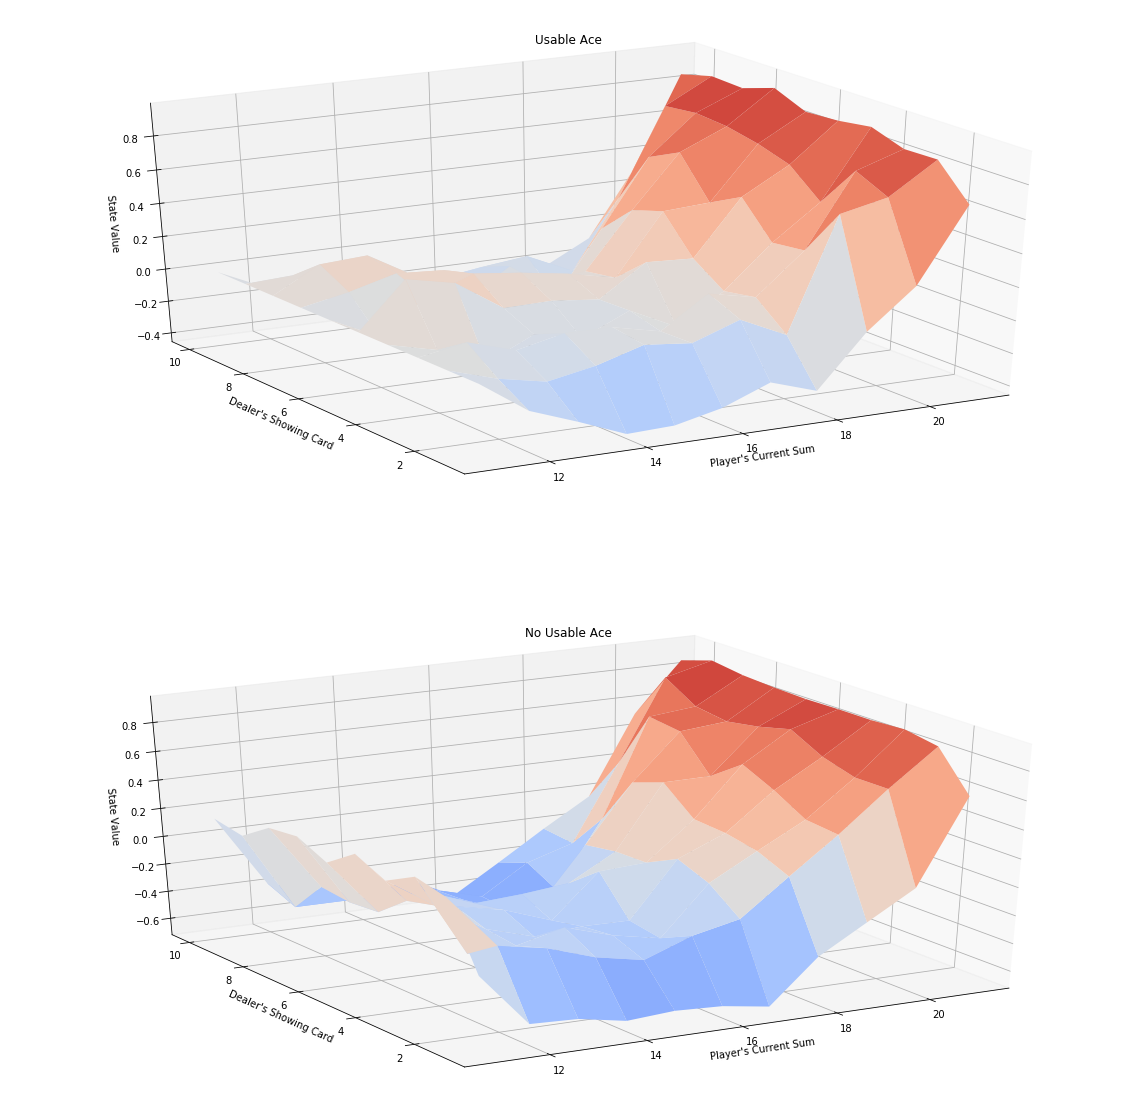

In [13]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

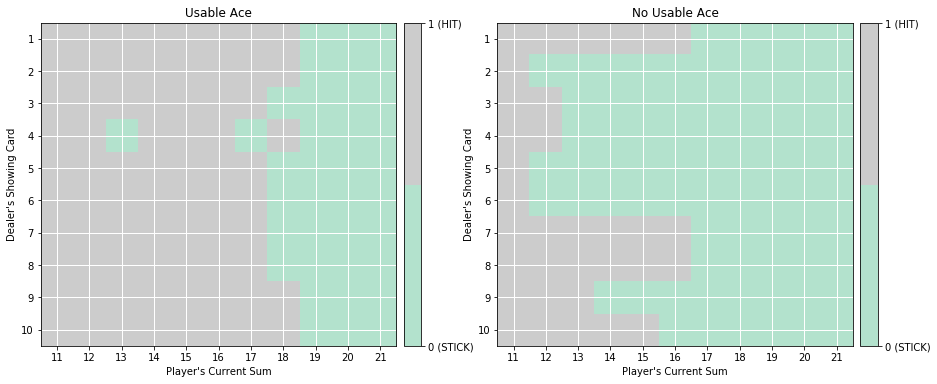

In [14]:
# plot the policy
plot_policy(policy_alpha)